<a href="https://colab.research.google.com/github/francescovannoni/FoodRecognitionChallenge/blob/master/FoodRecognitionChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Food Recognition Challenge**

Recognizing food from images is an extremely useful tool for a variety of use cases. In particular, it would allow people to track their food intake by simply taking a picture of what they consume. Food tracking can be of personal interest, and can often be of medical relevance as well. Medical studies have for some time been interested in the food intake of study participants but had to rely on food frequency questionnaires that are known to be imprecise.

The goal of this challenge is to train models which can look at images of food items and detect the individual food items present in them. We use a novel dataset of food images collected through the MyFoodRepo app where numerous volunteer Swiss users provide images of their daily food intake in the context of a digital cohort called Food & You. This growing data set has been annotated - or automatic annotations have been verified - with respect to segmentation, classification (mapping the individual food items onto an ontology of Swiss Food items), and weight/volume estimation.

###**Libraries and Constants** 

In [2]:
#import preprocessing
#import unet
import os
from pycocotools.coco import COCO
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import layers
!pip install segmentation_models
import segmentation_models as sm
import numpy as np
import json
import cv2
import collections
from tqdm import tqdm
import random

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
CATEGORIES = 16
N_MOST_COMMON = 14
EPOCHS = 1
BATCH_SIZE = 256

Segmentation Models: using `keras` framework.


### **Import Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def import_json_data():
    # load train annotations
    with open('/content/drive/MyDrive/DeepLearning/data/train/annotations.json') as json_file:
        train_coco_inp = json.load(json_file)
    print("Keys of train annotation file: ", train_coco_inp.keys())
    print("No of Categories(Classes) present: ", len(train_coco_inp['categories']))

    # load val annotations
    with open('/content/drive/MyDrive/DeepLearning/data/val/annotations.json') as json_file:
        val_coco_inp = json.load(json_file)
    print("Keys of val annotation file: ", val_coco_inp.keys())
    print("No of Categories(Classes) present: ", len(val_coco_inp['categories']))
    return train_coco_inp, val_coco_inp

In [5]:
train_coco_inp, val_coco_inp = import_json_data()

Keys of train annotation file:  dict_keys(['categories', 'info', 'images', 'annotations'])
No of Categories(Classes) present:  273
Keys of val annotation file:  dict_keys(['categories', 'info', 'images', 'annotations'])
No of Categories(Classes) present:  273


##**Data Cleaning**

We look for uncorrect annotations:

- rotated annotations with respect to images

- uncomplete coordinates

- empty annotations

In [7]:
def check_badannotation(coco_inp, train_val):
    useless = []
    for i in coco_inp['images']:
        im = cv2.imread("/content/drive/MyDrive/DeepLearning/data/" + train_val + f"/images/{i['file_name']}")
        if (im.shape[0] != i['height']) or (im.shape[1] != i['width']):
            os.remove("data/" + train_val + f"/images/{i['file_name']}")
            useless.append(i)

    print("Number of images with mismatching dimensions: ", len(useless))
    bad_ids = [item["id"] for item in useless]
    for i, item in enumerate(coco_inp['images']):
        if item["id"] in bad_ids:
            del coco_inp["images"][i]

    for i, item in enumerate(coco_inp['annotations']):
        if item["id"] in bad_ids:
            del coco_inp["annotations"][i]

    with open("/content/drive/MyDrive/DeepLearning/data/" + train_val + "/annotations_correct.json", "w") as f:
        f.write(json.dumps(coco_inp))

def check_non_empty_annotations(train_coco_inp):
    # checking if there are empty annotations
    count = 0
    for i in train_coco_inp["annotations"]:
        if not i["segmentation"][0]:
            count += 1
    print('Numbers of empty annotations: ', count)

def check_if_odd_annotations(train_coco_inp):
    # checking if there are annotations with missing numbers
    count = 0
    for i in train_coco_inp["annotations"]:
        if len(i["segmentation"][0]) % 2 == 1:
            count += 1
    print('Numbers of odd annotations: ', count)

In [8]:
if not os.path.exists("/content/drive/MyDrive/DeepLearning/data/train/annotations_correct.json"):
    check_badannotation(train_coco_inp, "train")
if not os.path.exists("/content/drive/MyDrive/DeepLearning/data/val/annotations_correct.json"):
    check_badannotation(val_coco_inp, "val")

check_if_odd_annotations(train_coco_inp)
check_non_empty_annotations(train_coco_inp)
#choosing_best_size(train_coco_inp)

Numbers of odd annotations:  0
Numbers of empty annotations:  0


## **Load COCO Dataset**

In [9]:
coco_train = COCO("/content/drive/MyDrive/DeepLearning/data/train/annotations_correct.json")
train_cat_ids = coco_train.getCatIds()
categories = coco_train.loadCats(train_cat_ids)
names = [c["name_readable"] for c in categories]
print("Number of different categories: ", len(names))
train_ann_ids = coco_train.getAnnIds()
train_anns = coco_train.loadAnns(train_ann_ids)

# VALIDATION DATA
coco_val = COCO("/content/drive/MyDrive/DeepLearning/data/val/annotations_correct.json")
val_cat_ids = coco_val.getCatIds()
val_ann_ids = coco_val.getAnnIds()
val_anns = coco_val.loadAnns(val_ann_ids)

loading annotations into memory...
Done (t=1.97s)
creating index...
index created!
Number of different categories:  273
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


## **Getting Most Common Categories**

In [17]:
def get_most_common(anns, n_most_common):  # get n most common categories and return dictionary
    # Loading into memory COCO dataset

    ann_categories = []
    for a in anns:
        ann_categories.append(a["category_id"])

    counter = collections.Counter(ann_categories)
    most_common = counter.most_common(n_most_common)
    most_common = dict(most_common)

    values = list(most_common.keys())

    # n most frequent categories (dictionary 1....n to cat_id, n+1 others, 0 background)
    id_correspondence = {values[i]: N_MOST_COMMON+1-i for i in range(0, len(values))}
    return id_correspondence, most_common

In [22]:
fifthy_most_common_id, fifthy_most_common_freq = get_most_common(train_anns, 50)

for i in list(fifthy_most_common_freq.keys()):
  for el in train_coco_inp["categories"]:
    if el["id"] == i:
      fifthy_most_common_freq[el["name_readable"]] = fifthy_most_common_freq.pop(i)

print(fifthy_most_common_freq)

most_common_ids, most_common_frequencies = get_most_common(train_anns, N_MOST_COMMON)

{'Water': 1836, 'Bread, white': 1276, 'Salad, leaf / salad, green': 1190, 'Tomato': 1072, 'Butter': 1010, 'Bread, wholemeal': 905, 'Carrot': 898, 'Coffee, with caffeine': 876, 'Rice': 659, 'Egg': 632, 'Mixed vegetables': 627, 'Wine, red': 546, 'Jam': 505, 'Apple': 504, 'Potatoes steamed': 452, 'Banana': 412, 'Cheese': 405, 'Espresso, with caffeine': 391, 'Cucumber': 383, 'Mixed salad (chopped without sauce)': 374, 'Tea': 353, 'Wine, white': 333, 'Hard cheese': 319, 'Avocado': 298, 'Tomato sauce': 291, 'Chicken': 280, 'Sweet pepper': 279, 'White coffee, with caffeine': 274, 'Broccoli': 262, 'Pasta, spaghetti': 255, 'Strawberries': 245, 'Chips, french fries': 238, 'Zucchini': 233, 'Honey': 230, 'Bread, whole wheat': 228, 'Dark chocolate': 213, 'Pizza, Margherita, baked': 206, 'Parmesan': 201, 'Mayonnaise': 198, 'Leaf spinach': 194, 'Braided white loaf': 194, 'Water, mineral': 185, 'GruyÃ¨re': 183, 'Soft cheese': 181, 'Salmon': 176, 'Salami': 173, 'Boisson au glucose 50g': 171, 'Juice, or

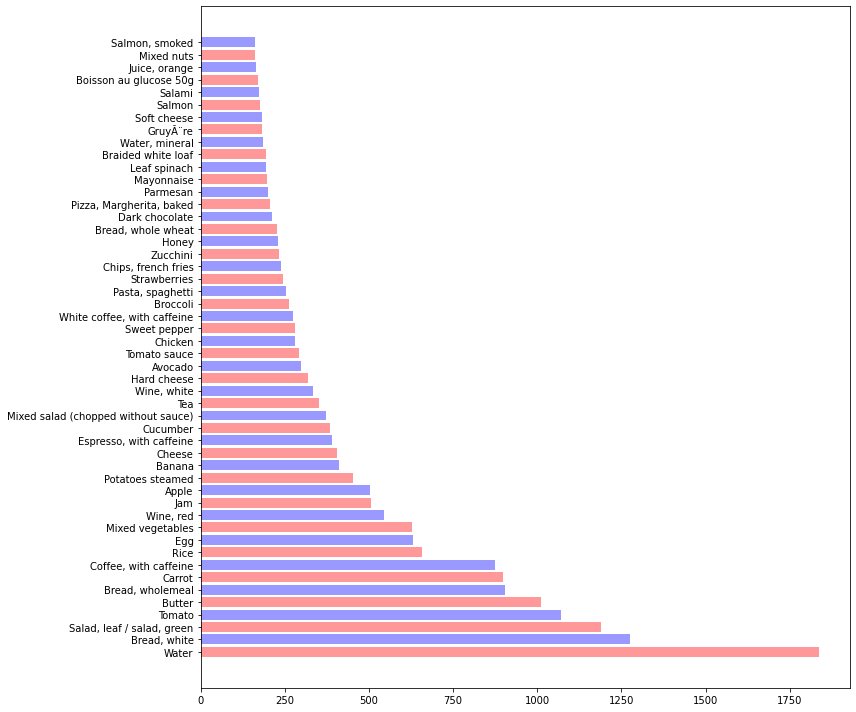

In [42]:
import numpy as np
import matplotlib.pyplot as plt

l = fifthy_most_common_freq
#l = dict((k,v) for k,v in l.items() if v>=500) prime 14
names = list(l.keys())
values = list(l.values())
'''
print(keys)
print(items)

x_pos = np.arange(len(keys))

plt.bar(x_pos, items, align='center')
plt.xticks(x_pos, keys)
plt.ylabel('Categorie più comuni')
plt.xlabel('Id')
plt.title('Frequenza')
plt.show()
'''

x  = np.array(names)
y = np.array(values)
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
yvals = range(len(names))
ax.barh(yvals, values, align='center', alpha=0.4, color=['red','blue'])
plt.yticks(yvals,names)
plt.tight_layout()

plt.show()

## **Mask Creator and Dataset Generator**

In [10]:
def get_mask(img_id, img_shape, coco_train, anns, most_common):
    mask = np.zeros((img_shape[0], img_shape[1], CATEGORIES))
    for ann in anns:
        if ann["image_id"] == img_id:
            if ann["category_id"] in most_common:
                mask[:, :, most_common[ann["category_id"]]] = coco_train.annToMask(ann)
            else:
                mask[:, :, 15] += coco_train.annToMask(ann)
    mask[:, :, 15][mask[:, :, 15] >= 1] = 1
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    return mask


def getImages(path):
    list_imgs = []
    for filename in tqdm(os.listdir(path)):
        list_imgs.append(filename)
    random.shuffle(list_imgs)
    return list_imgs


def generator(coco_data, anns, most_common, path, batch_size, list_imgs):
    list_imgs = list_imgs
    dataset_size = len(list_imgs)

    i = 0
    X = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    y = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, CATEGORIES))

    while True:
        for j in range(i, i + batch_size):
            img_id = int(list_imgs[j].lstrip("0").rstrip(".jpg"))  # getting image id
            img = cv2.imread(os.path.join(path, list_imgs[j]), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            y[j - i] = (get_mask(img_id, img.shape, coco_data, anns, most_common))
            X[j - i] = (cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)))

        i += batch_size
        if i + batch_size >= dataset_size:
            i = 0
            random.shuffle(list_imgs)
        yield X, y

In [11]:
train_images_name = getImages(path="/content/drive/MyDrive/DeepLearning/data/train/images")
dataset_train_size = len(train_images_name)

val_images_name = getImages(path="/content/drive/MyDrive/DeepLearning/data/val/images")
dataset_val_size = len(val_images_name)

train = generator(coco_train, train_anns, most_common_ids, path="/content/drive/MyDrive/DeepLearning/data/train/images/",  batch_size=BATCH_SIZE, list_imgs=train_images_name)

callbacks = [
    keras.callbacks.EarlyStopping(patience=4, monitor='accuracy'),  # monitor era val_loss
    keras.callbacks.TensorBoard(log_dir='logs')
]

100%|██████████| 1268/1268 [00:00<00:00, 1355345.94it/s]


## **U-Net Model**

descrizione u net model


### **Implementing U-Net Architecture**

In [16]:
FILTER = 16

def unet_model():
    # INPUT LAYER
    inputs = layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))  # PADDING?? PER ORA NO
    # we hve to work with floating point numbers, divide each pixel by 255
    s = layers.Lambda(lambda x: x / 255)(inputs)  # Normalization

    # CONTRACTION PATH
    # first convolutional layer
    c1 = layers.Conv2D(FILTER, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(s)
    # add dropout(10 percent from c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    # second layer of the first step
    c1 = layers.Conv2D(FILTER, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    # max pooling
    p1 = layers.MaxPool2D((2, 2))(c1)
    # c1 and p1 we have defined the first layer

    # kernel initializer: you have to start with some weights, these are the starting weights then
    # updated in the training #he normal as to do with normal distribution Centered around zero
    # truncated normal is another one (look at the documentation)

    # we add padding because we want the same input and output image size

    # relu sparsity, many zeros, satures, increase efficiency with regars to tiime and space
    # complexity because of sparsty and avoid the vanishing gradient problem

    # introduce the dead relu problem: network components most luckily neveer updates to a new value

    # UNET SEQUENTIAL OPERATOR

    c2 = layers.Conv2D(FILTER*2, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(FILTER*2, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = layers.MaxPool2D((2, 2))(c2)

    c3 = layers.Conv2D(FILTER*4, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(FILTER*4, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = layers.MaxPool2D((2, 2))(c3)

    c4 = layers.Conv2D(FILTER*8, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(FILTER*8, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = layers.MaxPool2D((2, 2))(c4)

    c5 = layers.Conv2D(FILTER*16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv2D(FILTER*16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)
    # ultimo è a 256

    # starting expansive path
    # ultimo era 256 quindi ridimezza 128
    # deconvolution is the opposite part of convolution
    u6 = layers.Conv2DTranspose(FILTER*8, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(FILTER*8, (3, 3), kernel_initializer='he_normal', activation="relu", padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(FILTER*8, (3, 3), kernel_initializer='he_normal', activation="relu", padding='same')(c6)

    u7 = layers.Conv2DTranspose(FILTER*4, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(FILTER*4, (3, 3), kernel_initializer='he_normal', activation="relu", padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Conv2D(FILTER*4, (3, 3), kernel_initializer='he_normal', activation="relu", padding='same')(c7)

    u8 = layers.Conv2DTranspose(FILTER*2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(FILTER*2, (3, 3), kernel_initializer='he_normal', activation="relu", padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Conv2D(FILTER*2, (3, 3), kernel_initializer='he_normal', activation="relu", padding='same')(c8)

    u9 = layers.Conv2DTranspose(FILTER, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(FILTER, (3, 3), kernel_initializer='he_normal', activation="relu", padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Conv2D(FILTER, (3, 3), kernel_initializer='he_normal', activation="relu", padding='same')(c9)

    # output

    # optimizer a lot of backpropagation to train model sgd, too mean square you can use more. most often adam
    # loss binary crossentropy
    # metric accuracy
    outputs = layers.Conv2D(CATEGORIES, (1, 1), activation="softmax")(c9)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


    # is summary num parameters is the number of trainable parameters
    model.summary()

    return model

### **Fitting and Training**

In [ ]:
print('Model adam dice')
adam_dice= unet.unet_model()
adam_dice.compile(optimizer='adam', loss=sm.losses.cce_dice_loss, metrics=['accuracy', sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])
adam_dice.fit(train, steps_per_epoch=dataset_train_size//BATCH_SIZE , epochs=EPOCHS, callbacks=callbacks)

print('Model adam focal')
adam_focal= unet.unet_model()
adam_focal.compile(optimizer='adam', loss=sm.losses.categorical_focal_loss, metrics=['accuracy', sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])
adam_focal.fit(train, steps_per_epoch=dataset_train_size//BATCH_SIZE , epochs=EPOCHS, callbacks=callbacks)

print('Model adam cce')
adam_cce= unet.unet_model()
adam_cce.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])
adam_cce.fit(train, steps_per_epoch=dataset_train_size//BATCH_SIZE , epochs=EPOCHS, callbacks=callbacks)

print('Model sgd dice')
sgd_dice= unet.unet_model()
sgd_dice.compile(optimizer='sgd', loss=sm.losses.cce_dice_loss, metrics=['accuracy', sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])
sgd_dice.fit(train, steps_per_epoch=dataset_train_size//BATCH_SIZE , epochs=EPOCHS, callbacks=callbacks)

print('Model sgd focal')
sgd_focal= unet.unet_model()
sgd_focal.compile(optimizer='sgd', loss=sm.losses.categorical_focal_loss, metrics=['accuracy', sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])
sgd_focal.fit(train, steps_per_epoch=dataset_train_size//BATCH_SIZE , epochs=EPOCHS, callbacks=callbacks)

print('Model sgd cce')
sgd_cce= unet.unet_model()
sgd_cce.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy', sm.metrics.iou_score, sm.metrics.precision, sm.metrics.recall])
sgd_cce.fit(train, steps_per_epoch=dataset_train_size//BATCH_SIZE , epochs=EPOCHS, callbacks=callbacks)